In [29]:
import inspect, os, sys

import re
import json
import statistics
import argparse
import itertools
from glob import glob
from pathlib import Path
from dataclasses import dataclass
from typing import  Iterable, Any


def cd_if_exists(dir: Path | str) -> bool:
    if isinstance(dir, str):
        dir = Path(dir)
    if dir.exists() and dir.is_dir():
        os.chdir(dir)
        return True
    else:
        return False

# Normally start VSCode (or whatever you use to run this notebook interactively) from the root, so
# we have to `cd` into the parent dir of this file, to access utils functions.
cd_if_exists('./scripts')

# These are util functions
from ldj import ldj
from utils import *

import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.font_manager import FontProperties
import matplotlib.font_manager as fm
from matplotlib.patches import FancyBboxPatch
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import PathPatch
from matplotlib.path import get_path_collection_extents
import seaborn as sns

from rich import print, pretty
from tabulate import tabulate
import pretty_errors
from catppuccin import PALETTE
from IPython.display import display, HTML

pretty.install()
print(f"{os.getcwd()=}")

EXPERIMENT_DIR = Path("../experiments/structured-junction-twoway")
assert EXPERIMENT_DIR.is_dir() and EXPERIMENT_DIR.exists()

flavor = PALETTE.latte.colors
# data = dict()


os.getcwd()='/home/kpbaks/university/semesters/10/master-thesis/gbp-rs/scripts'

In [35]:
# use LaTeX for text with matplotlib
sns.set_style("darkgrid")
# set background color of sns darkgrid to flavor.base.hex
plt.rcParams['axes.facecolor'] = flavor.base.hex
# set font color to flavor.text.hex
plt.rcParams['text.color'] = flavor.text.hex

font_dirs = ["./fonts/"]
# go through all fonts in the font directory and add them
for font_dir in font_dirs:
    for font in os.listdir(font_dir):
        fm.fontManager.addfont(f"{font_dir}/{font}")

prop_jbm = fm.FontProperties(fname='./fonts/JetBrainsMonoNerdFontMono-Regular.ttf')
prop = fm.FontProperties(fname='./fonts/STIXTwoText-VariableFont_wght.ttf')

plt.rcParams.update({
    # "text.usetex": True,
    "font.family": prop.get_name(),
    # "font.family": "stix",
    # "font.sans-serif": prop.get_name(),
    "mathtext.fontset": "stix",
    # "text.latex.preamble": r"\usepackage{fontenc}\usepackage{fontspec}\setmainfont{JetBrainsMonoNerdFontMono-Regular}",
})

print(prop.get_name())

colors = [
    (flavor.lavender.hex, 1.0, (1, 0), 'o'),
    (flavor.green.hex, 1.0, (2, 2), 'X'),
]

STIX Two Text

In [3]:
@dataclass(frozen=True)
class Statistics:
    mean: float
    median: float
    stdev: float
    min: float
    max: float


    def display(self) -> None:
        data = [
            ["Mean", self.mean],
            ["Median", self.median],
            ["Standard Deviation", self.stdev],
            ["Min", self.min],
            ["Max", self.max]
        ]
        html_table = tabulate(data, headers=["Statistic", "Value"], tablefmt="html")
        centered_html_table = f"""
        <div style="display: flex; justify-content: center;">
            {html_table}
        </div>
        """
        display(HTML(html_table))
        # display(HTML(centered_html_table))


def compute_stats(data: list[float]) -> Statistics:
    return Statistics(
        mean=np.mean(data),
        median=np.median(data),
        stdev=np.std(data),
        min=np.min(data),
        max=np.max(data),
    )


In [4]:
@dataclass(frozen=True)
class PerpendicularPositionErrorResult:
    errors: list[float]
    rmses: list[float]


def perpendicular_position_error(exported_data: dict) -> PerpendicularPositionErrorResult:
    errors: list[float] = []
    rmses: list[float] = []

    for robot_id, robot_data in exported_data['robots'].items():
        color: str = robot_data['color']
        positions = np.array([p for p in robot_data['positions']])
        mission = robot_data['mission']
        waypoints = []
        for route in mission['routes']:
            waypoints.append(route['waypoints'][0])
            for wp in route['waypoints'][1:]:
                waypoints.append(wp)

        waypoints = np.array(waypoints)
        waypoints = np.squeeze(waypoints)

        lines: list[LinePoints] = [LinePoints(start=start, end=end) for start, end in sliding_window(waypoints, 2)]
        closest_projections = [closest_projection_onto_line_segments(p, lines) for p in positions]

        error: float = np.sum(np.linalg.norm(positions - closest_projections, axis=1))
        rmse: float = np.sqrt(error / len(positions))

        errors.append(error)
        rmses.append(rmse)

    return PerpendicularPositionErrorResult(errors=errors, rmses=rmses)


In [5]:
@dataclass(frozen=True)
class CollisionsResult:
    interrobot: int
    environment: int

def collisions(exported_data: dict) -> CollisionsResult:
    interrobot: int = len(exported_data['collisions']['robots'])
    environment: int = len(exported_data['collisions']['environment'])
    return CollisionsResult(interrobot=interrobot, environment=environment)


In [147]:
@dataclass(frozen=True)
class TotalDistanceTravelledResult:
    distance: list[float]
    optimal_distance: list[float]

    @staticmethod
    def new() -> 'TotalDistanceTravelledResult':
        return TotalDistanceTravelledResult(distance=[], optimal_distance=[])

# def euclidian_distance(a: (float, float), b: (float, float)) -> float:
    

def total_distance_travelled(exported_data: dict) -> TotalDistanceTravelledResult:
    result = TotalDistanceTravelledResult.new()

    for robot_id, robot_data in exported_data['robots'].items():
        positions = np.array([p for p in robot_data['positions']])

        waypoints = []
        mission = robot_data['mission']
        for route in mission['routes']:
            waypoints.append(route['waypoints'][0])
            for wp in route['waypoints'][1:]:
                waypoints.append(wp)

        waypoints = np.array(waypoints)
        waypoints = np.squeeze(waypoints)

        def accumulated_distance(points):
            # Compute pairwise Euclidean distances between successive points
            distances = np.sum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1)))
            return distances

        optimal_distance = accumulated_distance(waypoints)
        total_distance_travelled = accumulated_distance(positions)
        result.distance.append(total_distance_travelled)
        result.optimal_distance.append(optimal_distance)


    return result

In [142]:
@dataclass(frozen=True)
class Metric:
    ppe: PerpendicularPositionErrorResult
    collisions: CollisionsResult
    total_distance_travelled: TotalDistanceTravelledResult


In [7]:
def flatten(lst: Iterable) -> list:
    return list(itertools.chain.from_iterable(lst))


In [148]:
@dataclass
class Results:
    with_tracking: dict[str, Metric]
    without_tracking: dict[str, Metric]

results = Results(dict(), dict())

RE = re.compile(r"tracking-(on|off)-failure-(\d\.\d)\.json")

for f in EXPERIMENT_DIR.iterdir():
    captures = RE.match(f.name)
    assert captures is not None
    tracking = captures.group(1)
    failure_prob = captures.group(2)

    with open(f) as f:
        data = json.load(f)

    ppe = perpendicular_position_error(data)
    dist_travelled = total_distance_travelled(data)
    metric = Metric(ppe=ppe, collisions=collisions(data), total_distance_travelled=dist_travelled)

    match tracking:
        case "on":
            results.with_tracking[failure_prob] = metric
        case "off":
            results.without_tracking[failure_prob] = metric
        case _:
            assert False


# print(f"{results=}")


In [149]:
results.with_tracking['0.0']


Metric(
    ppe=PerpendicularPositionErrorResult(
        errors=[
            111.29816000000004,
            106.06673359999999,
            17.88417770000007,
            21.12163800000003,
            25.603718200000046,
            37.1150764,
            45.46067049999999,
            149.51695030000005,
            7.813472091555695e-13,
            72.3756555,
            42.9793334,
            50.44335670000001
        ],
        rmses=[
            0.8314402680016518,
            0.8141972027709257,
            0.3160879739290475,
            0.34350833709479517,
            0.3782030299238435,
            0.43966770359367235,
            0.4686328687794776,
            0.9666855431705805,
            6.606866282567715e-08,
            0.6643154164709528,
            0.47190131026743753,
            0.49604954856762684
        ]
    ),
    collisions=CollisionsResult(interrobot=0, environment=0),
    total_distance_travelled=TotalDistanceTravelledResult(
        distance=[


## Perpendicular Position Error

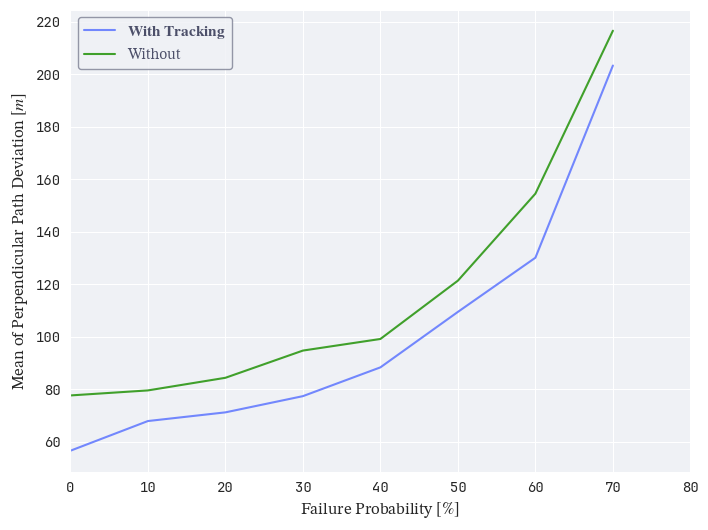

In [117]:
fig, ax = plt.subplots(1, figsize=(8, 6))

with_tracking_data = {k: compute_stats(v.ppe.errors).mean for k, v in sorted(results.with_tracking.items())}
without_tracking_data = {k: compute_stats(v.ppe.errors).mean for k, v in sorted(results.without_tracking.items())}

#      linestyle='--',

plt.plot(
    [float(k) for k in with_tracking_data.keys()],
    with_tracking_data.values(),
    # label="With Tracking"
    label="$\mathbf{With\ Tracking}$",
    color=flavor.lavender.hex,
)

plt.plot(
    [float(k) for k in without_tracking_data.keys()],
    without_tracking_data.values(),
    label="Without",
    color=flavor.green.hex,
)

legend = ax.legend(loc="upper left", fontsize=11)
# legend.get_frame().set_facecolor('#FF0000')  # Set the legend background color
legend.get_frame().set_edgecolor(flavor.overlay2.hex)  # Set the legend background color

# Define a formatter function
def percentage(x, pos):
    return f'{int(x * 100)}'

# Apply the formatter to the x-axis
ax.xaxis.set_major_formatter(FuncFormatter(percentage))

# Apply the custom font to x-ticks
for label in ax.get_xticklabels():
    label.set_fontproperties(prop_jbm)

for label in ax.get_yticklabels():
    label.set_fontproperties(prop_jbm)

label_args = dict(fontsize=12)

# ax.grid(True)
# ax.set_xlim(0, 0.8)
# ax.set_xlabel("Failure Probability $[\%]$", **label_args)
# # ax.set_xticks(np.arange(0, 0.8, 0.1))  # Setting xtick resolution to 0.1
# ax.set_ylabel("Total Collisions", **label_args)
# ax.set_title("Environment Collisions")
legend = ax.legend(loc="upper left", fontsize=11)
# legend.get_frame().set_facecolor('#FF0000')  # Set the legend background color
legend.get_frame().set_edgecolor(flavor.overlay2.hex)  # Set the legend background color

ax.grid(True)
ax.set_xlim(0, 0.8)
# ax.set_xticks(np.arange(0, 1.1, 0.1))  # Setting xtick resolution to 0.1
ax.set_ylabel("Mean of Perpendicular Path Deviation $[m]$", **label_args)
ax.set_xlabel("Failure Probability $[\%]$", **label_args)
# plt.tight_layout()
# ax.set_title("Mean of Perpendicular Path Deviation")
plt.savefig("perpendicular-path-deviation-structured-junction-twoway.svg", pad_inches=1.0)
plt.savefig("perpendicular-path-deviation-structured-junction-twoway.pdf")

plt.show()

## Collisions

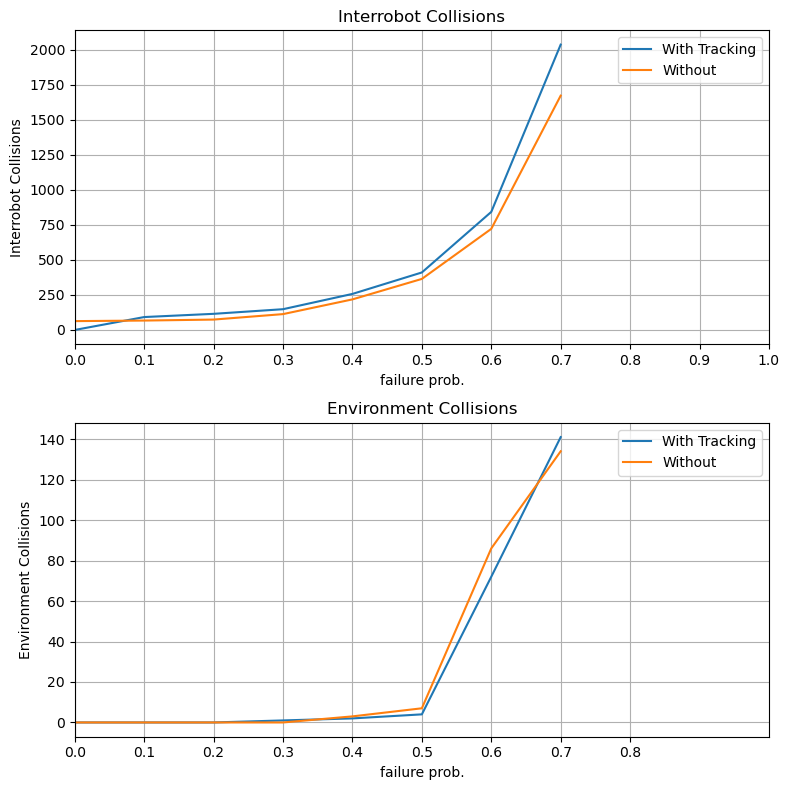

In [18]:
fig, axs = plt.subplots(2, figsize=(8,8))

ax = axs[0]

with_tracking_data = {k: v.collisions.interrobot for k, v in sorted(results.with_tracking.items())}
without_tracking_data = {k: v.collisions.interrobot for k, v in sorted(results.without_tracking.items())}

ax.plot(
    [float(k) for k in with_tracking_data.keys()],
    with_tracking_data.values(),
    label="With Tracking"
)

ax.plot(
    [float(k) for k in without_tracking_data.keys()],
    without_tracking_data.values(),
    label="Without"
)

ax.grid(True)
ax.set_xlim(0, 1)
ax.set_xticks(np.arange(0, 1.1, 0.1))  # Setting xtick resolution to 0.1
ax.set_xlabel("failure prob.")
ax.set_ylabel("Interrobot Collisions")
plt.tight_layout()
ax.set_title("Interrobot Collisions")
ax.legend()

ax = axs[1]

with_tracking_data = {k: v.collisions.environment for k, v in sorted(results.with_tracking.items())}
without_tracking_data = {k: v.collisions.environment for k, v in sorted(results.without_tracking.items())}

ax.plot(
    [float(k) for k in with_tracking_data.keys()],
    with_tracking_data.values(),
    label="With Tracking"
)

ax.plot(
    [float(k) for k in without_tracking_data.keys()],
    without_tracking_data.values(),
    label="Without"
)

ax.grid(True)
ax.set_xlim(0, 1)
ax.set_xlabel("failure prob.")
ax.set_xticks(np.arange(0, 0.9, 0.1))  # Setting xtick resolution to 0.1
ax.set_ylabel("Environment Collisions")
ax.set_title("Environment Collisions")
ax.legend()



plt.tight_layout()
plt.savefig("collisions-structured-junction-twoway.svg")
plt.show()


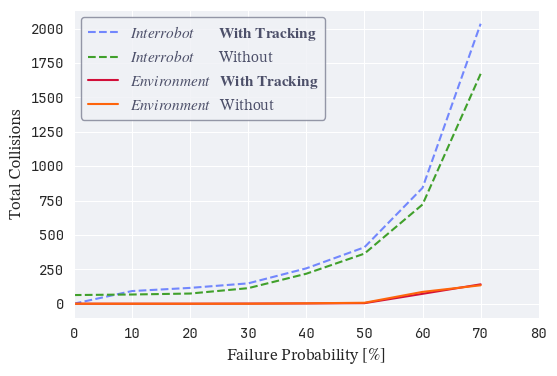

In [102]:
fix, ax = plt.subplots(1, figsize=(6,4))

# Interrobot
with_tracking_data = {k: v.collisions.interrobot for k, v in sorted(results.with_tracking.items())}
without_tracking_data = {k: v.collisions.interrobot for k, v in sorted(results.without_tracking.items())}

ax.plot(
    [float(k) for k in with_tracking_data.keys()],
    with_tracking_data.values(),
    label="$\mathit{Interrobot}$       $\mathbf{With\ Tracking}$",
    color=flavor.lavender.hex,
     linestyle='--',
)

ax.plot(
    [float(k) for k in without_tracking_data.keys()],
    without_tracking_data.values(),
    label="$\mathit{Interrobot}$       Without",
    color=flavor.green.hex,
    linestyle='--',
)

# Environment
with_tracking_data = {k: v.collisions.environment for k, v in sorted(results.with_tracking.items())}
without_tracking_data = {k: v.collisions.environment for k, v in sorted(results.without_tracking.items())}

ax.plot(
    [float(k) for k in with_tracking_data.keys()],
    with_tracking_data.values(),
    label="$\mathit{Environment}$   $\mathbf{With\ Tracking}$",
    color=flavor.red.hex
)

ax.plot(
    [float(k) for k in without_tracking_data.keys()],
    without_tracking_data.values(),
    label="$\mathit{Environment}$   Without",
    color=flavor.peach.hex
)

label_args = dict(fontsize=12)

ax.grid(True)
ax.set_xlim(0, 0.8)
ax.set_xlabel("Failure Probability $[\%]$", **label_args)
# ax.set_xticks(np.arange(0, 0.8, 0.1))  # Setting xtick resolution to 0.1
ax.set_ylabel("Total Collisions", **label_args)
# ax.set_title("Environment Collisions")
legend = ax.legend(loc="upper left", fontsize=11)
# legend.get_frame().set_facecolor('#FF0000')  # Set the legend background color
legend.get_frame().set_edgecolor(flavor.overlay2.hex)  # Set the legend background color

# Define a formatter function
def percentage(x, pos):
    return f'{int(x * 100)}'

# Apply the formatter to the x-axis
ax.xaxis.set_major_formatter(FuncFormatter(percentage))

# Apply the custom font to x-ticks
for label in ax.get_xticklabels():
    label.set_fontproperties(prop_jbm)

for label in ax.get_yticklabels():
    label.set_fontproperties(prop_jbm)

plt.yscale("linear")

# plt.tight_layout()
plt.savefig("collisions-structured-junction-twoway.svg")
plt.savefig("collisions-structured-junction-twoway.pdf")
plt.show()


In [11]:
{k: v.collisions for k, v in sorted(results.with_tracking.items())}


{
    '0.0': CollisionsResult(interrobot=0, environment=0),
    '0.1': CollisionsResult(interrobot=92, environment=0),
    '0.2': CollisionsResult(interrobot=115, environment=0),
    '0.3': CollisionsResult(interrobot=148, environment=1),
    '0.4': CollisionsResult(interrobot=257, environment=2),
    '0.5': CollisionsResult(interrobot=410, environment=4),
    '0.6': CollisionsResult(interrobot=842, environment=72),
    '0.7': CollisionsResult(interrobot=2035, environment=141)
}

# With Tracking

## Perpendicular Position Error

In [120]:
# for failure_prob, metric in sorted(results.with_tracking.items()):
#     print(f"{failure_prob=}")
#     compute_stats(metric.ppe.errors).display()

## Collisions

In [122]:
{k: v.collisions for k, v in sorted(results.with_tracking.items())}


{
    '0.0': CollisionsResult(interrobot=0, environment=0),
    '0.1': CollisionsResult(interrobot=92, environment=0),
    '0.2': CollisionsResult(interrobot=115, environment=0),
    '0.3': CollisionsResult(interrobot=148, environment=1),
    '0.4': CollisionsResult(interrobot=257, environment=2),
    '0.5': CollisionsResult(interrobot=410, environment=4),
    '0.6': CollisionsResult(interrobot=842, environment=72),
    '0.7': CollisionsResult(interrobot=2035, environment=141)
}

## Total Distance Travelled

# Without Tracking

## Perpendicular Position Error

In [121]:
# for failure_prob, metric in sorted(results.without_tracking.items()):
#     print(f"{failure_prob=}")
#     compute_stats(metric.ppe.errors).display()

## Collisions

In [14]:
{k: v.collisions for k, v in sorted(results.without_tracking.items())}


{
    '0.0': CollisionsResult(interrobot=63, environment=0),
    '0.1': CollisionsResult(interrobot=67, environment=0),
    '0.2': CollisionsResult(interrobot=74, environment=0),
    '0.3': CollisionsResult(interrobot=113, environment=0),
    '0.4': CollisionsResult(interrobot=218, environment=3),
    '0.5': CollisionsResult(interrobot=364, environment=7),
    '0.6': CollisionsResult(interrobot=721, environment=86),
    '0.7': CollisionsResult(interrobot=1671, environment=134)
}

In [60]:
os.getcwd()


'/home/kpbaks/university/semesters/10/master-thesis/gbp-rs/scripts'

In [134]:
import numpy as np
from scipy.spatial.distance import pdist, squareform


def pwdist(points: np.ndarray, distance_fn) -> np.ndarray:
    pass


# Example input array
# points = np.array([[x1, y1], [x2, y2], ..., [xn, yn]])
points = np.array([[0, 0], [1, 0], [1, 1], [1,2]])
dm = pdist(points, lambda u, v: np.sqrt(((u-v)**2).sum()))
print(f"{dm=}")


print(f"{pdist(points)=}")

print(f"{np.sum(pdist(points, 'euclidean'))=}")


# Compute pairwise Euclidean distances
# dist_matrix = squareform(pdist(points))

# Compute the accumulated distance
# accumulated_distance = np.sum(dist_matrix)
# print(f"{accumulated_distance=}")

dm=array([1.        , 1.41421356, 2.23606798, 1.        , 2.        ,
       1.        ])

pdist(points)=array([1.        , 1.41421356, 2.23606798, 1.        , 2.        ,
       1.        ])

np.sum(pdist(points, 'euclidean'))=8.650281539872886

In [139]:
def accumulated_distances(points):
    # Compute pairwise Euclidean distances between successive points
    distances = np.sum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1)))
    return distances

# Example usage
points = np.array([[0, 0], [1, 1], [2,2]])
accumulated_distances(points)

2.8284271247461903